## Predator - Prey Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import optimize

## Functions to Run the Model

In [2]:
# Define the predator-prey model based on your equations
def dNdt(state, t, parameters_dict):
    H, P = state  # Unpack state as H and P
    r_H = parameters_dict['r_H']
    K_H = parameters_dict['K_H']
    theta_H = parameters_dict['theta_H']
    c = parameters_dict['c']
    d = parameters_dict['d']
    q_H = parameters_dict['q_H']
    E_H = parameters_dict['E_H']
    r_P = parameters_dict['r_P']
    K_P = parameters_dict['K_P']
    b = parameters_dict['b']
    theta_P = parameters_dict['theta_P']
    q_P = parameters_dict['q_P']
    E_P = parameters_dict['E_P']
    
    # Equations for rate of change
    dH = r_H * H * (1 - H / K_H) - (c * H * P) / (d + H) + theta_H - q_H * E_H * H
    dP = r_P * P * (1 - P / K_P) + (b * H * P) / (d + H) + theta_P - q_P * E_P * P
    return [dH, dP]

In [3]:
def RK2(state, parameters_dict, t=0):
    H, P = state

    # Initial derivatives
    dH1, dP1 = dNdt(state, t, parameters_dict)

    # Intermediate step
    H1 = H + 0.5 * dH1
    P1 = P + 0.5 * dP1
    intermediate_state = [H1, P1]
    
    # Second derivatives at intermediate step
    dH2, dP2 = dNdt(intermediate_state, t, parameters_dict)

    # Average derivatives
    dH_ave = (dH1 + dH2) / 2
    dP_ave = (dP1 + dP2) / 2

    # Update state
    H = H + dH_ave
    P = P + dP_ave

    # Calculate harvest
    q_H = parameters_dict['q_H']  # Proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H']  # Effort for herbivore harvest
    q_P = parameters_dict['q_P']  # Proportionality constant for predator harvest
    E_P = parameters_dict['E_P']  # Effort for predator harvest

    herbivore_harvest = q_H * E_H * H
    predator_harvest = q_P * E_P * P

    return [H, P], herbivore_harvest, predator_harvest

In [4]:
def run_model(INIT_H, INIT_P, parameters_dict):
    numyears = parameters_dict['numyears']
    H_array = np.zeros(numyears + 1)
    P_array = np.zeros(numyears + 1)
    H_harvest_array = np.zeros(numyears + 1)
    P_harvest_array = np.zeros(numyears + 1)

    H_array[0] = INIT_H  # Starting biomass of herbivore
    P_array[0] = INIT_P  # Starting biomass of predator
    state = [INIT_H, INIT_P]

    # Simulation loop
    for i in np.arange(0, numyears):
        state, herbivore_harvest, predator_harvest = RK2(state, parameters_dict)
        H_array[i + 1], P_array[i + 1] = state
        H_harvest_array[i + 1] = herbivore_harvest
        P_harvest_array[i + 1] = predator_harvest

    return H_array, P_array, H_harvest_array, P_harvest_array

## Defining Default Parameters

In [5]:
def default_params():
    numyears = 100
    #Herbivore parameters:
    r_H = 0.4 # growth rate of herbivores
    K_H = 5000 # carrying capacity of herbivores
    theta_H = 50 # immigration of herbivores
    c = 0.1 #additional mortality of H 
    d = 500 # value of H when predation half its max value 
    q_H = 1. # proportionality constant for herbivore harvest 
    E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
    #Predator parameters:
    r_P = 0.2 # growth rate of predator 
    K_P = 2000 # carrying capactiy of predators
    b = 0.1 # additional growth of P due to H
    theta_P = 10 # immigration of predators 
    q_P = 1. # proportionality constant for predator harvest 
    E_P = 0.0 # Effort for predator harvest

    parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

    return parameters_dict

In [15]:
def default_fishing_params():
    numyears = 100
    #Herbivore parameters:
    r_H = 0.4 # growth rate of herbivores
    K_H = 5000 # carrying capacity of herbivores
    theta_H = 50 # immigration of herbivores
    c = 0.1 #additional mortality of H 
    d = 500 # value of H when predation half its max value 
    q_H = 1. # proportionality constant for herbivore harvest 
    E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
    #Predator parameters:
    r_P = 0.2 # growth rate of predator 
    K_P = 2000 # carrying capactiy of predators
    b = 0.1 # additional growth of P due to H
    theta_P = 10 # immigration of predators 
    q_P = 1. # proportionality constant for predator harvest 
    E_P = 0.4 # Effort for predator harvest

    parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

    return parameters_dict

### Set Up

In [26]:
# Define interaction strengths
numyears = 100
H0 = 100
P0 = 10
b_values = [0.1, 0.4, 0.6]
c_values = [0.1, 0.4, 0.6]
my_yticks = [0, 2000, 4000, 6000, 8000]

# Define subplot labels
subplot_labels = ["A", "B", "C", "D", "E", "F"]

# To store results
results = {}

## Running through each combination of b / c values for trajectories

In [27]:
parameters_dict = default_params()

# Run model for each combination of b and c and store in results
for i, b in enumerate(b_values):
    for j, c in enumerate(c_values):
        parameters_dict['b'] = b
        parameters_dict['c'] = c
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        T_array = H_array + P_array  # Total abundance
        
        # Store the results in a dictionary
        results[(i, j)] = {
            'H_array': H_array,
            'P_array': P_array,
            'T_array': T_array
        }

## Function for plotting nullclines and vector field

In [28]:
# Define the function to plot both the nullclines and vector field
def plot_nullclines_and_vector_field(ax, rh, kh, c, d, rp, kp, b, qh, Eh, qp, Ep, is_first_subplot):
    # Create grid for phase plane analysis
    H = np.linspace(-200, 8000, 20)  # Herbivore population
    P = np.linspace(-200, 8000, 20)  # Predator population
    H_grid, P_grid = np.meshgrid(H, P)
    
    # Set parameters for the model
    parameters_dict = {
        'r_H': rh, 'K_H': kh, 'theta_H': 0, 'c': c, 'd': d, 'q_H': qh, 'E_H': Eh,
        'r_P': rp, 'K_P': kp, 'b': b, 'theta_P': 0, 'q_P': qp, 'E_P': Ep
    }

    # Compute vector field
    dH_grid, dP_grid = np.zeros(H_grid.shape), np.zeros(P_grid.shape)
    for i in range(H_grid.shape[0]):
        for j in range(H_grid.shape[1]):
            dH_grid[i, j], dP_grid[i, j] = dNdt([H_grid[i, j], P_grid[i, j]], 0, parameters_dict)

    # Normalize vectors for plotting
    magnitude = np.sqrt(dH_grid**2 + dP_grid**2)
    dH_grid /= magnitude
    dP_grid /= magnitude

    # Create a grid of points for nullclines
    x_vals = np.linspace(-200, 8000, 100)
    y_vals = np.linspace(-200, 8000, 100)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Nullcline for Prey (H)
    dHdt = (rh * X * ((kh - X) / kh)) - ((c * X * Y) / (d + X)) - (qh * Eh * X)
    # Nullcline for Predator (P)
    dPdt = (rp * Y * ((kp - Y) / kp)) + ((b * X * Y) / (d + X)) - (qp * Ep * Y)

    # Plot the vector field (gray arrows)
    ax.quiver(H_grid, P_grid, dH_grid, dP_grid, color="gray", alpha=0.6, angles="xy")
    
    # Prey Nullcline: where dHdt = 0
    prey_nullcline = ax.contour(X, Y, dHdt, levels=[0], colors="green")
    
    # Predator Nullcline: where dPdt = 0
    predator_nullcline = ax.contour(X, Y, dPdt, levels=[0], colors="purple")

    # Labels and title
    ax.set_xlabel("Prey Abundance", fontsize = 16)
    ax.set_ylabel("Predator Abundance", fontsize = 16)
    ax.set_title(f"$b$ = {b}, $c$ = {c}", fontsize = 18)
    
    # Manually creating the legend for nullclines only in the first subplot
    if is_first_subplot:
        ax.legend([prey_nullcline.collections[0], predator_nullcline.collections[0]],
                  ["Prey Nullcline", "Predator Nullcline"],
                  loc="upper right", fontsize = 14)

## Plot

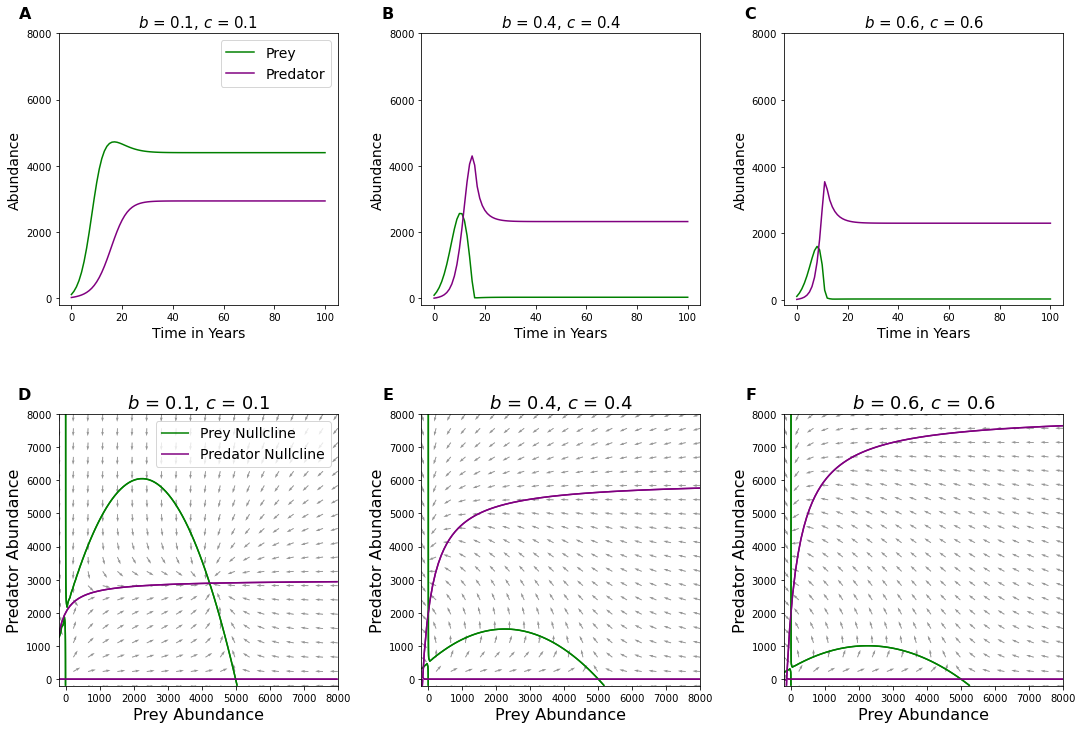

In [29]:
# Create subplots for different b, c combinations
b_c_values = [(0.1, 0.1), (0.4, 0.4), (0.6, 0.6)]
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Loop through the subplots and plot for each b, c combination
for i, (b, c) in enumerate(b_c_values):
    # Plot trajectories in the top row
    H_array = results[(i, i)]['H_array']
    P_array = results[(i, i)]['P_array']
    T_array = results[(i, i)]['T_array']
    
    axs[0, i].plot(range(numyears + 1), H_array, label='Prey', color="green")
    axs[0, i].plot(range(numyears + 1), P_array, label='Predator', color="purple")
    axs[0, i].set_title(f'$b$ = {b}, $c$ = {c}', fontsize=15)
    axs[0, i].set_yticks(my_yticks)
    axs[0, i].set_xlabel('Time in Years', fontsize=14)
    axs[0, i].set_ylabel('Abundance', fontsize=14)

    # Add legend only for the first trajectory subplot
    if i == 0:
        axs[0, i].legend(fontsize=14)
    
    # Add subplot label in the top-left corner
    axs[0, i].text(-0.1, 1.1, subplot_labels[i], transform=axs[0, i].transAxes,
                   fontsize=16, fontweight="bold", va="top", ha="right")

    # Plot nullclines in the bottom row
    plot_nullclines_and_vector_field(axs[1, i], 0.4, 5000, c, 500, 0.2, 2000, b, 1.0, 0.0, 1.0, 0.0, is_first_subplot=(i==0))

    # Add subplot label in the top-left corner
    axs[1, i].text(-0.1, 1.1, subplot_labels[i + 3], transform=axs[1, i].transAxes,
                   fontsize=16, fontweight="bold", va="top", ha="right")

    # Plot nullclines in the bottom row
    plot_nullclines_and_vector_field(axs[1, i], 0.4, 5000, c, 500, 0.2, 2000, b, 1.0, 0.0, 1.0, 0.0, is_first_subplot=(i==0))

## Add a common title to the figure
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

## Add Predator Fishing

In [32]:
numyears = 100
H0 = 100
P0 = 10
parameters_dict = default_fishing_params()

# Run model for each combination of b and c and store in results
for i, b in enumerate(b_values):
    for j, c in enumerate(c_values):
        parameters_dict['b'] = b
        parameters_dict['c'] = c
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        T_array = H_array + P_array  # Total abundance
        
        # Store the results in a dictionary
        results[(i, j)] = {
            'H_array': H_array,
            'P_array': P_array,
            'T_array': T_array
        }

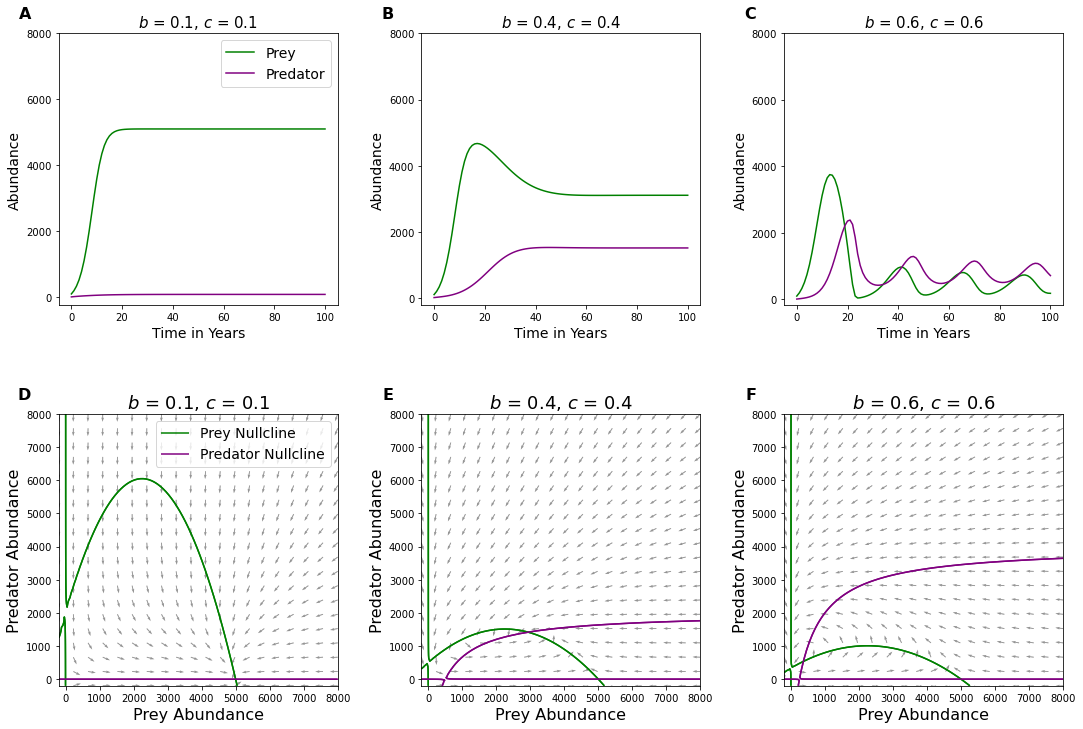

In [33]:
# Create subplots for different b, c combinations
b_c_values = [(0.1, 0.1), (0.4, 0.4), (0.6, 0.6)]
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Loop through the subplots and plot for each b, c combination
for i, (b, c) in enumerate(b_c_values):
    # Plot trajectories in the top row
    H_array = results[(i, i)]['H_array']
    P_array = results[(i, i)]['P_array']
    T_array = results[(i, i)]['T_array']
    
    axs[0, i].plot(range(numyears + 1), H_array, label='Prey', color="green")
    axs[0, i].plot(range(numyears + 1), P_array, label='Predator', color="purple")
    axs[0, i].set_title(f'$b$ = {b}, $c$ = {c}', fontsize=15)
    axs[0, i].set_yticks(my_yticks)
    axs[0, i].set_xlabel('Time in Years', fontsize=14)
    axs[0, i].set_ylabel('Abundance', fontsize=14)

    # Add legend only for the first trajectory subplot
    if i == 0:
        axs[0, i].legend(fontsize=14)
    
    # Add subplot label in the top-left corner
    axs[0, i].text(-0.1, 1.1, subplot_labels[i], transform=axs[0, i].transAxes,
                   fontsize=16, fontweight="bold", va="top", ha="right")

    # Plot nullclines in the bottom row
    plot_nullclines_and_vector_field(axs[1, i], 0.4, 5000, c, 500, 0.2, 2000, b, 1.0, 0.0, 1.0, 0.4, is_first_subplot=(i==0))

    # Add subplot label in the top-left corner
    axs[1, i].text(-0.1, 1.1, subplot_labels[i + 3], transform=axs[1, i].transAxes,
                   fontsize=16, fontweight="bold", va="top", ha="right")

    # Plot nullclines in the bottom row
    plot_nullclines_and_vector_field(axs[1, i], 0.4, 5000, c, 500, 0.2, 2000, b, 1.0, 0.0, 1.0, 0.4, is_first_subplot=(i==0))

## Add a common title to the figure
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()